In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

import scores

import scipy

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [4]:
""" 

    load dataset

"""

res = np.load( precomputed_path + 'res/' + 'res_999.npy', allow_pickle=True, encoding='latin1' )
res = dict( res.item() )
scores_fz = np.load( precomputed_path + 'scores/' + 'scores_999.npy', allow_pickle=True, encoding='latin1' )
scores_fz = dict( scores_fz.item() )
log_info = np.load( precomputed_path + 'log_info/' + 'log_info_999.npy', allow_pickle=True, encoding='latin1' )
log_info = dict( log_info.item() )

print( f'loaded res: { res.keys() }' )
print( f'loaded scores: { scores_fz.keys() }' )
print( f'loaded log_info: { log_info.keys() }' )

loaded res: dict_keys(['lstm', 'bottleneck', 'pos_xy'])
loaded scores: dict_keys(['btln_60_separation', 'lstm_90', 'btln_60', 'btln_90_separation', 'btln_90', 'lstm_60'])
loaded log_info: dict_keys(['train_op', 'epoch', 'total_loss'])


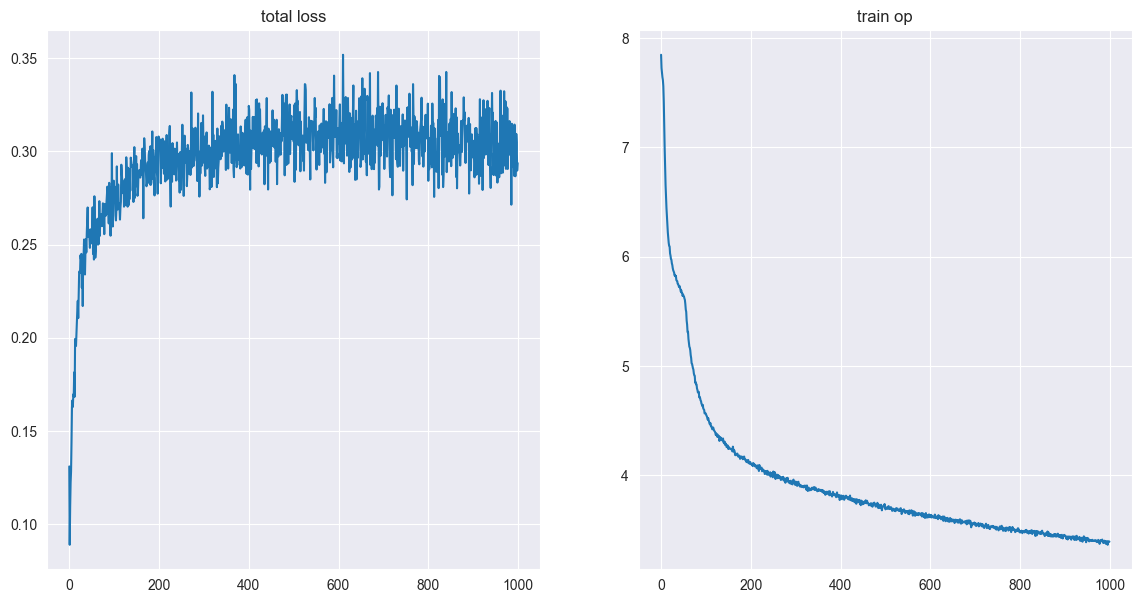

In [5]:
""" 

    loss viz

"""

fig, axs = plt.subplots( 1 , 2, figsize=( 14, 7 ) )

axs[ 0 ].plot( log_info['total_loss'] )
axs[ 0 ].set_title( 'total loss' )

axs[ 1 ].plot( log_info['train_op'] )
axs[ 1 ].set_title( 'train op' )

plt.show()

In [6]:
""" 

    get scores

"""

res_pos = res[ 'pos_xy' ]
res_btln = res[ 'bottleneck' ]

print('')
print( f'sample_res_pos: { res_pos.shape }' )
print( f'sample_res_btln: { res_btln.shape }' )
print('')


sample_res_pos: (4000, 100, 2)
sample_res_btln: (4000, 100, 512)



In [7]:
""" 

    get scorer objects

"""

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
masks_parameters = zip(starts, ends.tolist())

coord_range = ( (-1.1, 1.1), (-1.1, 1.1) )

res = 20
latest_epoch_scorer = scores.GridScorer( res, coord_range, masks_parameters )

# concatenate trajectories
xy = res_pos.reshape(-1, res_pos.shape[-1])
act = res_btln.reshape(-1, res_btln.shape[-1])
n_units = act.shape[1]

print('')
print( f'xy: { xy.shape }' )
print( f'act: { act.shape }' )
print( f'n_units: { n_units }' )
print('')

# get ratemap for each unit
s = [ latest_epoch_scorer.calculate_ratemap(xy[:, 0], xy[:, 1], act[:, i]) for i in tqdm(range(n_units)) ]

# Get the scores
score_60, score_90, max_60_mask, max_90_mask, sac = zip( * [ latest_epoch_scorer.get_scores( rate_map ) for rate_map in tqdm( s ) ] )


xy: (400000, 2)
act: (400000, 512)
n_units: 512



  0%|          | 0/512 [00:00<?, ?it/s]/Users/no_lineal/Documents/GitHub/dm-grid-cells/scores.py:138: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
100%|██████████| 512/512 [00:03<00:00, 160.24it/s]


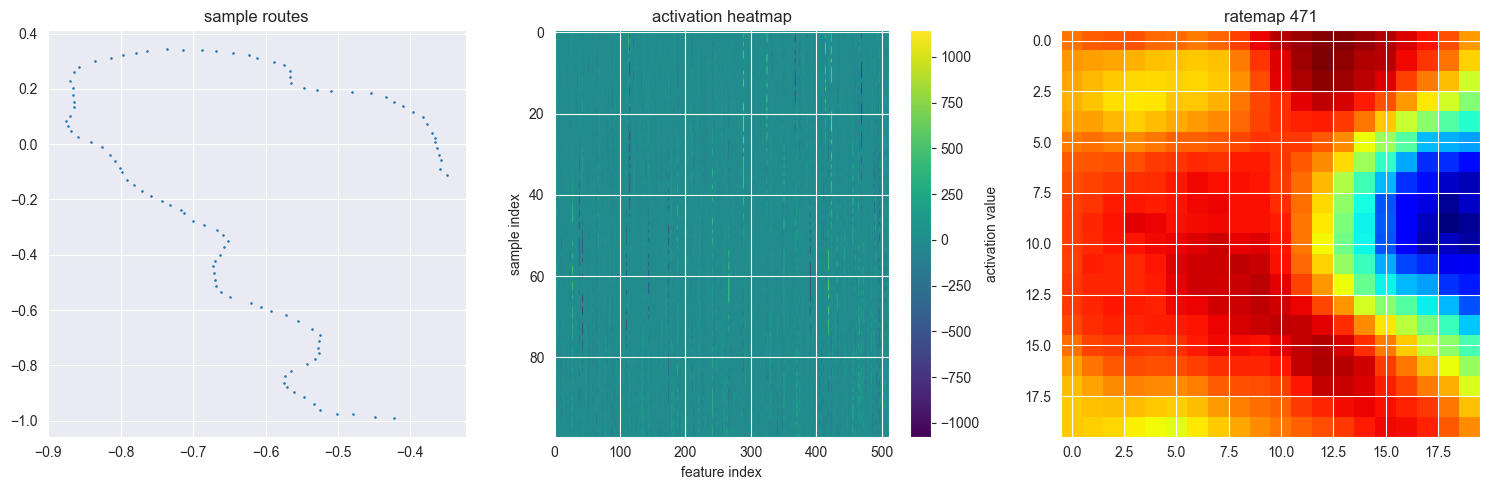

In [8]:
""" 

    viz 

"""

sample_idx = np.random.choice( range(len(s)) )
sample_idx = 471
#sample_idx = 48
#sample_idx = 399
sample_s = s[ sample_idx ]

# route viz

lb_route = 0
ub_route = 100

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 2 columns

# Scatter plot
axs[0].scatter(xy[ lb_route : ub_route, 0], xy[ lb_route : ub_route, 1], marker='.', s=3)
axs[0].set_title('sample routes')

# Heatmap
aux = act[ lb_route : ub_route ]
heatmap = axs[1].imshow(aux, cmap='viridis', aspect='auto')  # You can choose a different colormap if needed
axs[1].set_title('activation heatmap')
axs[1].set_xlabel('feature index')
axs[1].set_ylabel('sample index')

# Add colorbar
cbar = plt.colorbar(heatmap, ax=axs[1])
cbar.set_label('activation value')

# Ratemap
heatmap = axs[2].imshow(sample_s, cmap='jet', aspect='auto')  # You can choose a different colormap if needed
axs[2].set_title( f'ratemap { sample_idx }')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

/var/folders/g5/_2g0311j2w93w086_s60pvtc0000gn/T/ipykernel_2071/1689278160.py:58: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
/var/folders/g5/_2g0311j2w93w086_s60pvtc0000gn/T/ipykernel_2071/1689278160.py:156: RuntimeWarning: invalid value encountered in divide
  axs[ 12, 1 ].imshow( np.divide(covar, np.multiply(std_seq1, std_seq2)) , cmap='jet', aspect='auto')
/var/folders/g5/_2g0311j2w93w086_s60pvtc0000gn/T/ipykernel_2071/1689278160.py:158: RuntimeWarning: invalid value encountered in divide
  axs[ 12, 2 ].imshow( np.real( np.divide(covar, np.multiply(std_seq1, std_seq2)) ) , cmap='jet', aspect='auto')


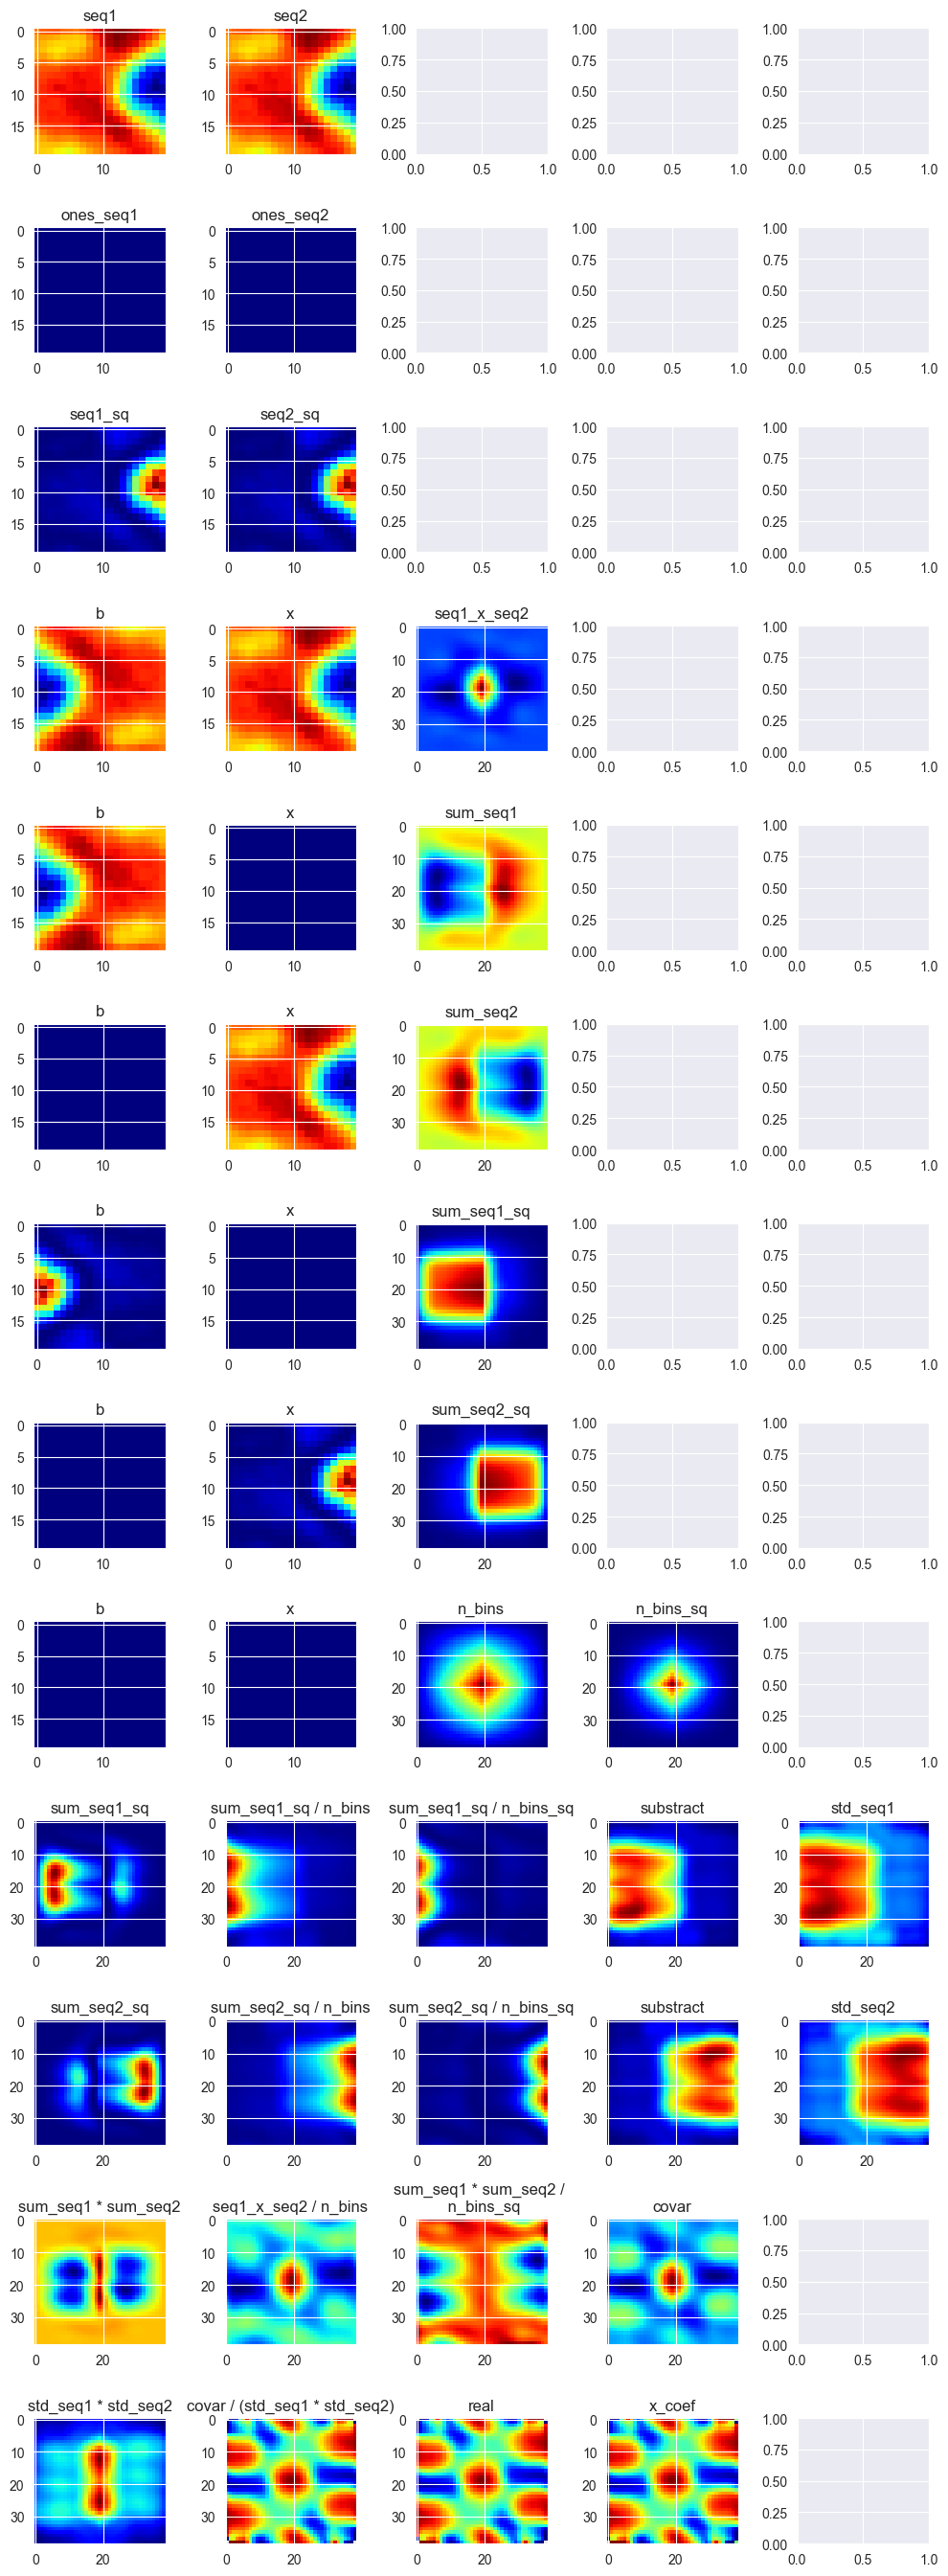

In [9]:
""" 

    step sac

"""

def filter2(b, x):
    
    stencil = np.rot90(b, 2)
    return scipy.signal.convolve2d(x, stencil, mode='full')

seq1 = sample_s.copy()
seq2 = sample_s.copy()

ones_seq1 = np.ones(seq1.shape)
ones_seq1[np.isnan(seq1)] = 0

ones_seq2 = np.ones(seq2.shape)
ones_seq2[np.isnan(seq2)] = 0

seq1[np.isnan(seq1)] = 0
seq2[np.isnan(seq2)] = 0

seq1_sq = np.square(seq1)
seq2_sq = np.square(seq2)

seq1_x_seq2 = filter2(seq1, seq2)
sum_seq1 = filter2(seq1, ones_seq2)
sum_seq2 = filter2(ones_seq1, seq2)
sum_seq1_sq = filter2(seq1_sq, ones_seq2)
sum_seq2_sq = filter2(ones_seq1, seq2_sq)
n_bins = filter2(ones_seq1, ones_seq2)
n_bins_sq = np.square(n_bins)

std_seq1 = np.power(
    np.subtract( 
        np.divide(sum_seq1_sq, n_bins), 
        (
            np.divide( np.square(sum_seq1), n_bins_sq)
        )
    ), 0.5
)

std_seq2 = np.power( 
    np.subtract( 
        np.divide(sum_seq2_sq, n_bins), 
        (
            np.divide(np.square(sum_seq2), n_bins_sq)
        )
    ), 0.5
)

covar = np.subtract( 
    np.divide(seq1_x_seq2, n_bins), 
    np.divide(np.multiply(sum_seq1, sum_seq2), n_bins_sq)
)

x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))
x_coef = np.real(x_coef)
x_coef = np.nan_to_num(x_coef)

fig, axs = plt.subplots(13, 5, figsize=(10, 27))  # 1 row, 2 columns

axs[ 0, 0 ].imshow(seq1, cmap='jet', aspect='auto')  
axs[ 0, 0 ].set_title('seq1')
axs[ 0, 1 ].imshow(seq2, cmap='jet', aspect='auto') 
axs[ 0, 1 ].set_title('seq2')

axs[ 1, 0 ].imshow(ones_seq1, cmap='jet', aspect='auto')
axs[ 1, 0 ].set_title('ones_seq1')
axs[ 1, 1 ].imshow(ones_seq2, cmap='jet', aspect='auto')
axs[ 1, 1 ].set_title('ones_seq2')

axs[ 2, 0 ].imshow(seq1_sq, cmap='jet', aspect='auto')
axs[ 2, 0 ].set_title('seq1_sq')
axs[ 2, 1 ].imshow(seq2_sq, cmap='jet', aspect='auto')
axs[ 2, 1 ].set_title('seq2_sq')

axs[ 3, 0 ].imshow( np.rot90( seq1, 2 ) , cmap='jet', aspect='auto')
axs[ 3, 0 ].set_title('b')
axs[ 3, 1 ].imshow( seq2 , cmap='jet', aspect='auto')
axs[ 3, 1 ].set_title('x')
axs[ 3, 2 ].imshow( seq1_x_seq2 , cmap='jet', aspect='auto')
axs[ 3, 2 ].set_title('seq1_x_seq2')

axs[ 4, 0 ].imshow( np.rot90( seq1, 2 ) , cmap='jet', aspect='auto')
axs[ 4, 0 ].set_title('b')
axs[ 4, 1 ].imshow( ones_seq2 , cmap='jet', aspect='auto')
axs[ 4, 1 ].set_title('x')
axs[ 4, 2 ].imshow( sum_seq1 , cmap='jet', aspect='auto')
axs[ 4, 2 ].set_title('sum_seq1')

axs[ 5, 0 ].imshow( np.rot90( ones_seq1, 2 ) , cmap='jet', aspect='auto')
axs[ 5, 0 ].set_title('b')
axs[ 5, 1 ].imshow( seq2 , cmap='jet', aspect='auto')
axs[ 5, 1 ].set_title('x')
axs[ 5, 2 ].imshow( sum_seq2 , cmap='jet', aspect='auto')
axs[ 5, 2 ].set_title('sum_seq2')

axs[ 6, 0 ].imshow( np.rot90( seq1_sq, 2 ) , cmap='jet', aspect='auto')
axs[ 6, 0 ].set_title('b')
axs[ 6, 1 ].imshow( ones_seq2 , cmap='jet', aspect='auto')
axs[ 6, 1 ].set_title('x')
axs[ 6, 2 ].imshow( sum_seq1_sq , cmap='jet', aspect='auto')
axs[ 6, 2 ].set_title('sum_seq1_sq')

axs[ 7, 0 ].imshow( np.rot90( ones_seq1, 2 ) , cmap='jet', aspect='auto')
axs[ 7, 0 ].set_title('b')
axs[ 7, 1 ].imshow( seq2_sq , cmap='jet', aspect='auto')
axs[ 7, 1 ].set_title('x')
axs[ 7, 2 ].imshow( sum_seq2_sq , cmap='jet', aspect='auto')
axs[ 7, 2 ].set_title('sum_seq2_sq')

axs[ 8, 0 ].imshow( np.rot90( ones_seq1, 2 ) , cmap='jet', aspect='auto')
axs[ 8, 0 ].set_title('b')
axs[ 8, 1 ].imshow( ones_seq2 , cmap='jet', aspect='auto')
axs[ 8, 1 ].set_title('x')
axs[ 8, 2 ].imshow( n_bins , cmap='jet', aspect='auto')
axs[ 8, 2 ].set_title('n_bins')
axs[ 8, 3 ].imshow( n_bins_sq , cmap='jet', aspect='auto')
axs[ 8, 3 ].set_title('n_bins_sq')

axs[ 9, 0 ].imshow( np.square(sum_seq1) , cmap='jet', aspect='auto')
axs[ 9, 0 ].set_title('sum_seq1_sq')
axs[ 9, 1 ].imshow( np.divide(sum_seq1_sq, n_bins) , cmap='jet', aspect='auto')
axs[ 9, 1 ].set_title('sum_seq1_sq / n_bins')
axs[ 9, 2 ].imshow( np.divide( np.square(sum_seq1), n_bins_sq) , cmap='jet', aspect='auto')
axs[ 9, 2 ].set_title('sum_seq1_sq / n_bins_sq')
axs[ 9, 3 ].imshow( np.subtract( np.divide(sum_seq1_sq, n_bins), ( np.divide( np.square(sum_seq1), n_bins_sq) ) ) , cmap='jet', aspect='auto')
axs[ 9, 3 ].set_title('substract')
axs[ 9, 4 ].imshow( std_seq1 , cmap='jet', aspect='auto')
axs[ 9, 4 ].set_title('std_seq1')

axs[ 10, 0 ].imshow( np.square(sum_seq2) , cmap='jet', aspect='auto')
axs[ 10, 0 ].set_title('sum_seq2_sq')
axs[ 10, 1 ].imshow( np.divide(sum_seq2_sq, n_bins) , cmap='jet', aspect='auto')
axs[ 10, 1 ].set_title('sum_seq2_sq / n_bins')
axs[ 10, 2 ].imshow( np.divide( np.square(sum_seq2), n_bins_sq) , cmap='jet', aspect='auto')
axs[ 10, 2 ].set_title('sum_seq2_sq / n_bins_sq')
axs[ 10, 3 ].imshow( np.subtract( np.divide(sum_seq2_sq, n_bins), ( np.divide( np.square(sum_seq2), n_bins_sq) ) ) , cmap='jet', aspect='auto')
axs[ 10, 3 ].set_title('substract')
axs[ 10, 4 ].imshow( std_seq2 , cmap='jet', aspect='auto')
axs[ 10, 4 ].set_title('std_seq2')

axs[ 11, 0 ].imshow( np.multiply(sum_seq1, sum_seq2) , cmap='jet', aspect='auto')
axs[ 11, 0 ].set_title('sum_seq1 * sum_seq2')
axs[ 11, 1 ].imshow( np.divide(seq1_x_seq2, n_bins) , cmap='jet', aspect='auto')
axs[ 11, 1 ].set_title('seq1_x_seq2 / n_bins')
axs[ 11, 2 ].imshow( np.divide(np.multiply(sum_seq1, sum_seq2), n_bins_sq) , cmap='jet', aspect='auto')
axs[ 11, 2 ].set_title('sum_seq1 * sum_seq2 / \n n_bins_sq')
axs[ 11, 3 ].imshow( covar , cmap='jet', aspect='auto')
axs[ 11, 3 ].set_title('covar')

axs[ 12, 0 ].imshow( np.multiply(std_seq1, std_seq2) , cmap='jet', aspect='auto')
axs[ 12, 0 ].set_title('std_seq1 * std_seq2')
axs[ 12, 1 ].imshow( np.divide(covar, np.multiply(std_seq1, std_seq2)) , cmap='jet', aspect='auto')
axs[ 12, 1 ].set_title('covar / (std_seq1 * std_seq2)')
axs[ 12, 2 ].imshow( np.real( np.divide(covar, np.multiply(std_seq1, std_seq2)) ) , cmap='jet', aspect='auto')
axs[ 12, 2 ].set_title('real')
axs[ 12, 3 ].imshow( x_coef , cmap='jet', aspect='auto')
axs[ 12, 3 ].set_title('x_coef')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()